# Use xESMF to perform spatial averages

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np
import xarray as xr
import xesmf as xe

pd.set_option('display.max_rows', None)

Through the use of the ESMF "Mesh", xESMF is able regrid to/from a list of polygons. For non-conservative methods, this is equivalent to using a "locstream" of the polygon centroids. But for conservative methods, regridding from a grid to polygons corresponds to a spatial averaging operation. ESMF meshes do not support the complexity available with shapely's (Multi)Polyons as mesh elements can not have holes or multiple non-touching parts. Thus, the default `Regridder` object has the same limitations. These problems are solved with the `xe.SpatialAverager` class.

Warning: xESMF does not depend on `Geopandas`, but it is used here for examples as it offers a simple and efficient container for polygons.

## Simple example

### Prepare input data

In [62]:
# Load some polygons from the internet
regs = gpd.read_file('https://cdn.jsdelivr.net/npm/world-atlas@2/countries-10m.json')
# Select a few countries for the sake of the example
regs = regs.iloc[[5, 9, 37, 67, 98, 155]]
# Simplify the geometries to a 0.04 deg tolerance, which is 1/50 of our grid.
# The simpler the polygons, the faster the averaging, but we lose some precision.
regs['geometry'] = regs.simplify(tolerance=0.04, preserve_topology=True)
regs

,id,name,geometry
5,032,Argentina,"MULTIPOLYGON (((-67.19287 -22.82225, -67.02727..."
9,156,China,"MULTIPOLYGON (((77.79858 35.49614, 77.41337 35..."
37,710,South Africa,"MULTIPOLYGON (((19.98200 -24.75230, 20.36360 -..."
67,724,Spain,"MULTIPOLYGON (((-5.34065 35.84736, -5.37665 35..."
98,466,Mali,"POLYGON ((-12.26352 14.77561, -12.06912 14.735..."
155,484,Mexico,"MULTIPOLYGON (((-97.13797 25.96581, -97.16677 ..."


In [50]:
# Fake temperature data for North America
ds = xe.util.grid_global(2, 2)
ds = ds.assign(tas=xe.data.wave_smooth(ds.lon, ds.lat))
ds

<xarray.Dataset>
Dimensions:  (x: 180, x_b: 181, y: 90, y_b: 91)
Coordinates:
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon_b    (y_b, x_b) int64 -180 -178 -176 -174 -172 ... 172 174 176 178 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    tas      (y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0

<AxesSubplot:xlabel='lon', ylabel='lat'>

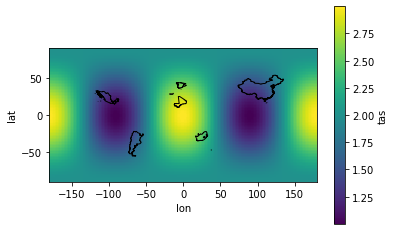

In [51]:
fig, ax = plt.subplots()
ds.tas.plot(ax=ax, x='lon', y='lat')
regs.plot(ax=ax, edgecolor='k', facecolor='none')

### Build a Spatial averager and perform the average

In [52]:
savg = xe.SpatialAverager(ds, regs.geometry)
savg

xESMF SpatialAverager 
Weight filename:            spatialavg_90x180_6.nc 
Reuse pre-computed weights? False 
Input grid shape:           (90, 180) 
Output list length:         6 

As the `SpatialAverager` is a special case of xESMF's `Regridder`, its behavior is very similar, but some options are hardcoded. For instance, it uses the "conservative" regridding method and ouputs something similar to when a `locstream` is used as a destination. In the result, the `lon` and `lat` coordinates are the centroids of each polygon.

In [53]:
out = savg(ds.tas)
out

/home/phobos/Python/xESMF/xesmf/frontend.py:514: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.DataArray 'tas' (locations: 6)>
array([1.58448962, 1.49192741, 2.48193206, 2.57407912, 2.89307769,
       1.26271597])
Coordinates:
    lon      (locations) float64 -65.18 103.8 25.09 -3.641 -3.538 -102.5
    lat      (locations) float64 -35.39 36.56 -29.0 40.23 17.34 23.95
Dimensions without coordinates: locations
Attributes:
    regrid_method:  conservative

As the order of the polygons is conserved in the output, we can add this data back to our dataframe with:

In [54]:
regs['tas_avg'] = out.values
regs

/home/phobos/.conda/envs/xxx/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,id,name,geometry,size,tas_avg
5,032,Argentina,"MULTIPOLYGON (((-67.19287 -22.82225, -67.02727...",546,1.584490
9,156,China,"MULTIPOLYGON (((77.79858 35.49614, 77.41337 35...",1881,1.491927
37,710,South Africa,"MULTIPOLYGON (((19.98200 -24.75230, 20.36360 -...",187,2.481932
67,724,Spain,"MULTIPOLYGON (((-5.34065 35.84736, -5.37665 35...",344,2.574079
98,466,Mali,"POLYGON ((-12.26352 14.77561, -12.06912 14.735...",175,2.893078
155,484,Mexico,"MULTIPOLYGON (((-97.13797 25.96581, -97.16677 ...",822,1.262716


<AxesSubplot:xlabel='lon', ylabel='lat'>

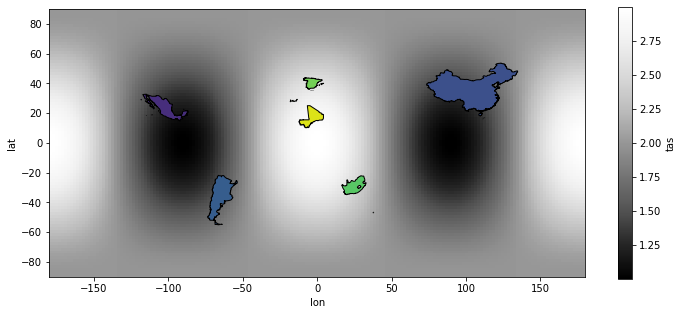

In [61]:
fig, ax = plt.subplots(figsize=(12, 5))
ds.tas.plot(ax=ax, x='lon', y='lat',cmap='Greys_r')
regs.plot(column='tas_avg', ax=ax, edgecolor='k', vmin=1, vmax=3, cmap='viridis')